# Gamer ErgoVision - Complete Pipeline Notebook

This notebook provides an interactive guide to using the Gamer ErgoVision system for hand-invariant posture classification.

**What you'll learn:**
- ✅ Setup and verify installation
- ✅ Extract pose features from images
- ✅ Load and prepare datasets
- ✅ Train the hybrid model
- ✅ Make predictions on new images
- ✅ Evaluate model performance
- ✅ Visualize results

**Expected Runtime:**
- Setup & Testing: ~5 minutes
- Training (if included): ~30-45 minutes (GPU) / 2-3 hours (CPU)
- Inference & Evaluation: ~5 minutes

---

## Section 0: Setup & Installation

First, let's install all required dependencies and verify the installation.

In [1]:
# Install dependencies (uncomment if needed)
# !pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118  # For CUDA 11.8
# !pip install opencv-python mediapipe numpy pandas scikit-learn matplotlib seaborn tqdm pillow

In [2]:
# Verify installation
import torch
import cv2
import mediapipe
import numpy as np
import matplotlib.pyplot as plt

print("✅ Installation Check:")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
print(f"OpenCV Version: {cv2.__version__}")
print(f"MediaPipe Version: {mediapipe.__version__}")
print(f"NumPy Version: {np.__version__}")

# Enable inline plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

✅ Installation Check:
PyTorch Version: 2.5.1
CUDA Available: True
CUDA Device: NVIDIA GeForce RTX 4050 Laptop GPU
OpenCV Version: 4.12.0
MediaPipe Version: 0.10.9
NumPy Version: 2.0.1


In [3]:
# Import project modules
import sys
from pathlib import Path

# Add project root to path (adjust if needed)
project_root = Path.cwd()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Project Root: {project_root}")

# Import all necessary modules
from v2.config import *
from v2.models.hybrid_model import create_model, HybridPostureClassifier
from v2.data.datasets import InvariantPostureDataset, create_dataloaders
from v2.utils.pose_features import SideViewPoseFeatureExtractor
from v2.utils.transforms import get_posture_transforms

print("✅ All modules imported successfully!")

Project Root: c:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch
✅ All modules imported successfully!


---
## 🎯 Section 1: Pose Feature Extraction Demo

Let's test the MediaPipe pose extraction and visualize the 24 hand-invariant features.

In [4]:
# Initialize pose extractor
pose_extractor = SideViewPoseFeatureExtractor()

# Function to visualize pose extraction
def demo_pose_extraction(image_path):
    """
    Extract and visualize pose features from an image.
    """
    # Load image
    image = cv2.imread(str(image_path))
    if image is None:
        print(f"❌ Error: Could not load image from {image_path}")
        return None
    
    # Extract pose features
    result = pose_extractor.extract_features(image)
    
    if result is None:
        print("❌ Error: Could not detect pose in image")
        return None
    
    features, debug_info = result
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original image
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axes[0].imshow(image_rgb)
    axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Pose overlay
    pose_image = pose_extractor.visualize_pose(
        image,
        debug_info['landmarks'],
        debug_info['side']
    )
    pose_image_rgb = cv2.cvtColor(pose_image, cv2.COLOR_BGR2RGB)
    axes[1].imshow(pose_image_rgb)
    axes[1].set_title(f'Detected Pose (Side: {debug_info["side"]})', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    # Feature visualization
    axes[2].bar(range(len(features)), features, color='skyblue', edgecolor='black', alpha=0.7)
    axes[2].set_xlabel('Feature Index', fontsize=12)
    axes[2].set_ylabel('Feature Value', fontsize=12)
    axes[2].set_title('24 Geometric Features', fontsize=14, fontweight='bold')
    axes[2].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print key metrics
    print("\n" + "="*60)
    print("POSE EXTRACTION RESULTS")
    print("="*60)
    print(f"Detected Side: {debug_info['side']}")
    print(f"Spine Angle: {debug_info['spine_angle']:.2f}°")
    print(f"Head Forward Distance: {debug_info['head_forward_distance']:.3f}")
    print(f"Total Features: {len(features)}")
    print("="*60)
    
    return features, debug_info

print("Pose extraction function ready!")
print("\nUsage: demo_pose_extraction('path/to/your/image.jpg')")

Pose extraction function ready!

Usage: demo_pose_extraction('path/to/your/image.jpg')



Testing with image: C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\v2\data\raw\test\backwardbadposture\backward_lean_bad_posture-33-_jpg.rf.3b1414aa99efd16b3ecafd1f2065f31e.jpg
✅ Image loaded: (640, 640, 3)
Extracting features...

POSE EXTRACTION SUCCESS
Detected Side: left
Spine Angle: 38.23°
Head Forward Distance: 0.100
Total Features: 24

✅ Visualization saved to: pose_test_result.png


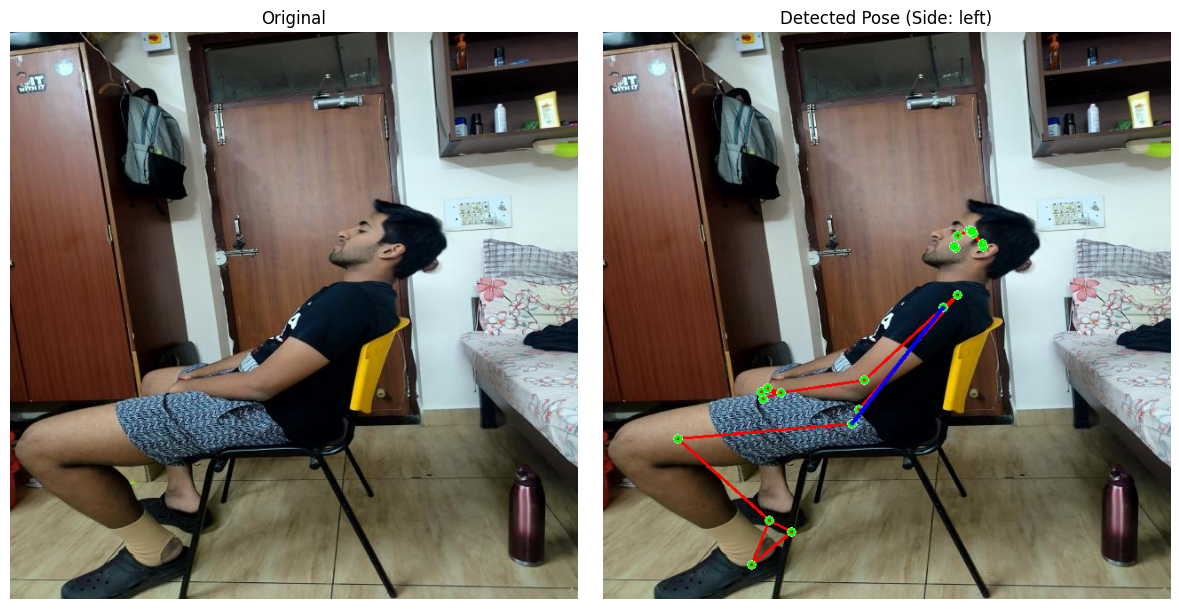

In [5]:
from v2.scripts.test_pose_extraction import test_with_image

test_with_image(r'C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\v2\data\raw\test\backwardbadposture\backward_lean_bad_posture-33-_jpg.rf.3b1414aa99efd16b3ecafd1f2065f31e.jpg')

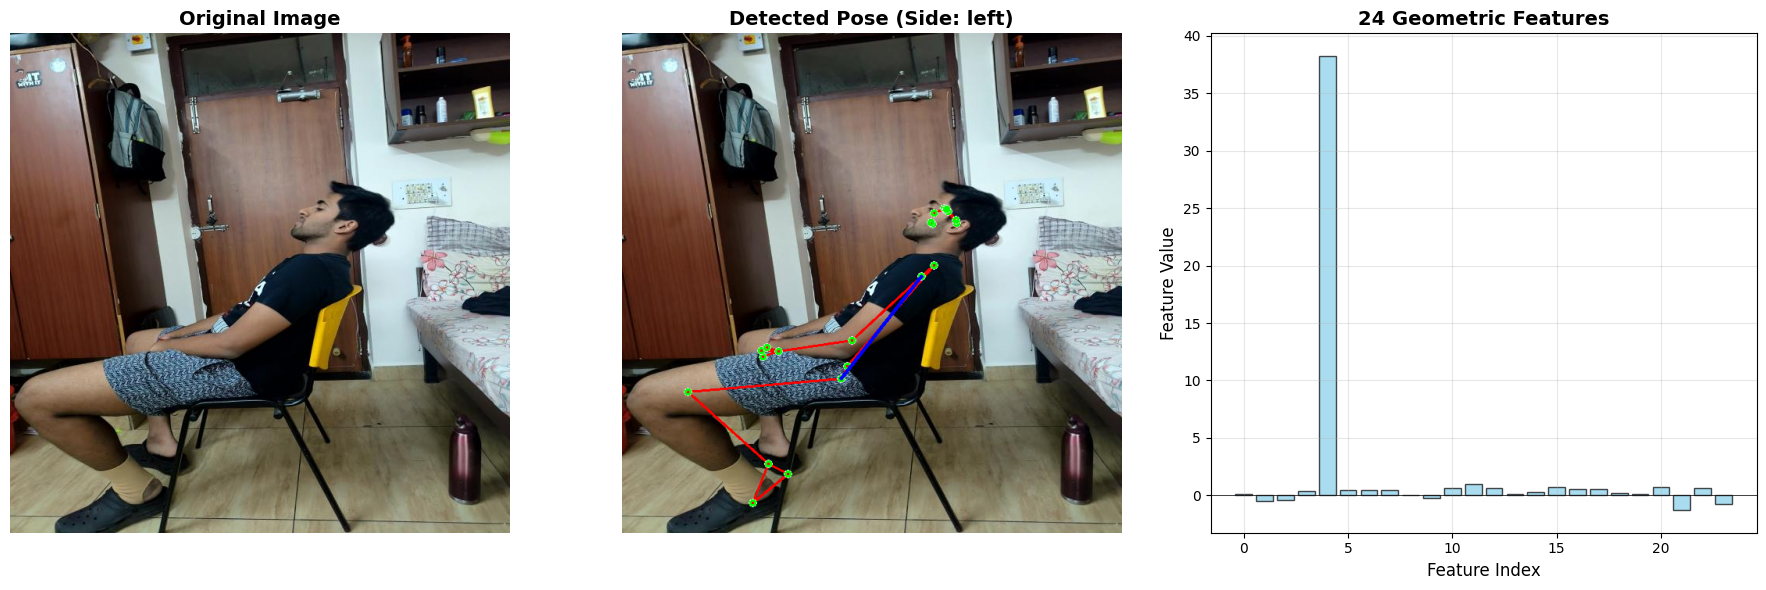


POSE EXTRACTION RESULTS
Detected Side: left
Spine Angle: 38.23°
Head Forward Distance: 0.100
Total Features: 24


In [6]:
# TEST: Extract pose from a sample image
# Replace with your actual image path
sample_image_path = r"C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\v2\data\raw\test\backwardbadposture\backward_lean_bad_posture-33-_jpg.rf.3b1414aa99efd16b3ecafd1f2065f31e.jpg"

# Uncomment to test with your image:
features, debug_info = demo_pose_extraction(sample_image_path)

---
## Section 2: Model Creation & Architecture

Let's create the hybrid model and examine its architecture.

In [7]:
# Set device
device = get_device()
print(f"Using device: {device}")

# Create model
model = create_model(
    fusion_type='concatenation',  # Options: 'concatenation', 'weighted_addition', 'cross_attention'
    pretrained=True,
    device=device
)

Using device: cuda


c:\Users\Admin\anaconda3\envs\ergovision\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\ergovision\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MODEL ARCHITECTURE
Fusion Type: concatenation
Total Parameters: 11,543,236
Trainable Parameters: 11,543,236
Model Size: 44.03 MB (float32)


In [8]:
# Test model with dummy inputs
print("\nTesting model forward pass...")

batch_size = 4
dummy_images = torch.randn(batch_size, 3, 224, 224).to(device)
dummy_pose = torch.randn(batch_size, 24).to(device)

with torch.no_grad():
    logits = model(dummy_images, dummy_pose)
    probabilities = torch.softmax(logits, dim=1)

print(f"✅ Input images shape: {dummy_images.shape}")
print(f"✅ Input pose shape: {dummy_pose.shape}")
print(f"✅ Output logits shape: {logits.shape}")
print(f"✅ Output probabilities shape: {probabilities.shape}")
print(f"\nSample predictions (probabilities):")
for i in range(batch_size):
    print(f"  Sample {i+1}: {probabilities[i].cpu().numpy()}")


Testing model forward pass...
✅ Input images shape: torch.Size([4, 3, 224, 224])
✅ Input pose shape: torch.Size([4, 24])
✅ Output logits shape: torch.Size([4, 3])
✅ Output probabilities shape: torch.Size([4, 3])

Sample predictions (probabilities):
  Sample 1: [0.27413455 0.3129956  0.4128698 ]
  Sample 2: [0.34320453 0.31342247 0.34337306]
  Sample 3: [0.3243057 0.2960874 0.3796069]
  Sample 4: [0.3744878  0.31578448 0.3097277 ]


---
## Section 3: Dataset Preparation

Prepare your dataset for training and evaluation.

In [9]:
# Configure dataset paths
# IMPORTANT: Update these paths to your actual data directories

import os

proj_path = os.getcwd()

TRAIN_DIR = r"C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\yolo_dataset\train"  # Update this
VAL_DIR = r"C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\yolo_dataset\val"      # Update this
TEST_DIR = r"C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\yolo_dataset\test"    # Update this


print("📂 Dataset Configuration:")
print(f"Train Directory: {TRAIN_DIR}")
print(f"Val Directory: {VAL_DIR}")
print(f"Test Directory: {TEST_DIR}")
print("\n⚠️ Make sure these directories exist and contain subdirectories:")
print("  - goodposture/")
print("  - forwardbadposture/")
print("  - backwardbadposture/")

📂 Dataset Configuration:
Train Directory: C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\yolo_dataset\train
Val Directory: C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\yolo_dataset\val
Test Directory: C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\yolo_dataset\test

⚠️ Make sure these directories exist and contain subdirectories:
  - goodposture/
  - forwardbadposture/
  - backwardbadposture/


In [10]:
# Check if dataset directories exist
from pathlib import Path

def check_dataset_structure(base_dir):
    """Check if dataset directory has correct structure."""
    base_path = Path(base_dir)
    
    if not base_path.exists():
        print(f"❌ Directory not found: {base_dir}")
        return False
    
    required_classes = ['goodposture', 'forwardbadposture', 'backwardbadposture']
    
    for class_name in required_classes:
        class_path = base_path / class_name
        if not class_path.exists():
            print(f"❌ Missing class directory: {class_path}")
            return False
        
        # Count images
        images = list(class_path.glob('*.jpg')) + \
                 list(class_path.glob('*.jpeg')) + \
                 list(class_path.glob('*.png'))
        print(f"✅ {class_name}: {len(images)} images")
    
    return True

print("Checking dataset structure...\n")
train_ok = check_dataset_structure(TRAIN_DIR)
print()
val_ok = check_dataset_structure(VAL_DIR)
print()
test_ok = check_dataset_structure(TEST_DIR)

if train_ok and val_ok:
    print("\n✅ Dataset structure looks good!")
else:
    print("\n⚠️ Please fix dataset structure before proceeding.")

Checking dataset structure...

✅ goodposture: 654 images
✅ forwardbadposture: 328 images
✅ backwardbadposture: 330 images

✅ goodposture: 95 images
✅ forwardbadposture: 45 images
✅ backwardbadposture: 46 images

✅ goodposture: 41 images
✅ forwardbadposture: 29 images
✅ backwardbadposture: 24 images

✅ Dataset structure looks good!


In [11]:
# Create dataloaders (only if dataset exists)
# This will take some time as it extracts and caches pose features

# Set to True when you're ready to load the dataset

LOAD_DATASET = True  # Change to True when dataset is ready

if LOAD_DATASET:
    print("Loading datasets and extracting pose features...")
    print("⏳ This may take a few minutes...\n")
    
    dataloaders = create_dataloaders(
        train_dir=TRAIN_DIR,
        val_dir=VAL_DIR,
        test_dir=TEST_DIR if Path(TEST_DIR).exists() else None,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        extract_pose_features=True
    )
    
    train_loader = dataloaders['train']
    val_loader = dataloaders['val']
    test_loader = dataloaders.get('test', None)
    
    print("\n✅ Dataloaders created successfully!")
else:
    print("⏭️ Skipping dataset loading. Set LOAD_DATASET=True when ready.")

Loading datasets and extracting pose features...
⏳ This may take a few minutes...

Loading train dataset from C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\yolo_dataset\train...
Found 1312 images in 3 classes
Extracting pose features for train split...


Extracting poses: 100%|██████████| 1312/1312 [00:41<00:00, 31.73it/s]


Successfully extracted 982 pose features
Failed to detect pose in 330 images
Loading val dataset from C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\yolo_dataset\val...
Found 186 images in 3 classes
Extracting pose features for val split...


Extracting poses: 100%|██████████| 186/186 [00:05<00:00, 34.47it/s]


Successfully extracted 180 pose features
Failed to detect pose in 6 images
Loading test dataset from C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\yolo_dataset\test...
Found 94 images in 3 classes
Extracting pose features for test split...


Extracting poses: 100%|██████████| 94/94 [00:02<00:00, 33.10it/s]

Successfully extracted 91 pose features
Failed to detect pose in 3 images

DATASET STATISTICS
Train samples: 982
Val samples: 180
Test samples: 91

Train class distribution:
  backwardbadposture: 245
  forwardbadposture: 268
  goodposture: 469

Val class distribution:
  backwardbadposture: 43
  forwardbadposture: 42
  goodposture: 95


✅ Dataloaders created successfully!


Batch shapes:
  Images: torch.Size([128, 3, 224, 224])
  Pose features: torch.Size([128, 24])
  Labels: torch.Size([128])


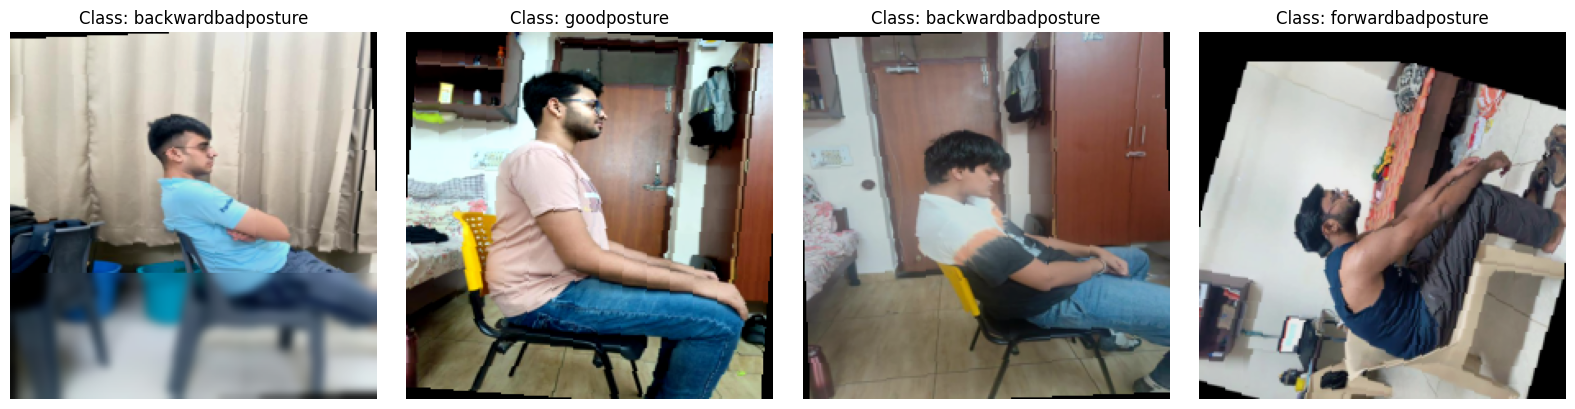

In [12]:
# Visualize sample batch (if dataset loaded)
if LOAD_DATASET and 'train_loader' in locals():
    # Get a batch
    images, pose_features, labels = next(iter(train_loader))
    
    print(f"Batch shapes:")
    print(f"  Images: {images.shape}")
    print(f"  Pose features: {pose_features.shape}")
    print(f"  Labels: {labels.shape}")
    
    # Visualize first 4 images
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    for i in range(min(4, len(images))):
        # Denormalize image
        img = images[i].cpu().numpy().transpose(1, 2, 0)
        img = img * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {POSTURE_CLASSES[labels[i]]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("⏭️ Skipping batch visualization (dataset not loaded)")

---
## Section 4: Model Training

Train the hybrid model with consistency regularization.

⚠️ **Note:** Training takes 30-45 minutes on GPU or 2-3 hours on CPU.
You can skip this section if you have a pre-trained model.

In [ ]:
# Import training modules
from v2.scripts.train_invariant import Trainer, ConsistencyLoss

# Set to True to start training
START_TRAINING = True  # Change to True when ready to train

if START_TRAINING and LOAD_DATASET:
    print("🚀 Starting training...\n")
    
    # Create fresh model for training
    model = create_model(device=device)
    
    # Create trainer
    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        learning_rate=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY
    )
    
    # Train model
    trainer.train(num_epochs=NUM_EPOCHS)
    
    print("\n✅ Training complete!")
    print(f"Best validation accuracy: {trainer.best_val_acc:.2f}%")
    print(f"Best model saved to: {get_model_save_path(best=True)}")
    
else:
    print("⏭️ Skipping training.")
    print("   Set START_TRAINING=True and LOAD_DATASET=True to train.")
    print("   Or load a pre-trained checkpoint in the next section.")

c:\Users\Admin\anaconda3\envs\ergovision\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


🚀 Starting training...

MODEL ARCHITECTURE
Fusion Type: concatenation
Total Parameters: 11,543,236
Trainable Parameters: 11,543,236
Model Size: 44.03 MB (float32)

STARTING TRAINING


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.46s/it, loss=0.0055, acc=75.00%]



Epoch 1/30 Summary:
  Train - Loss: 0.7231, Cls: 0.7210, Cons: 0.0070, Acc: 65.48%
  Val   - Loss: 0.6038, Acc: 75.00%
  LR: 0.001000
  Checkpoint saved to c:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\v2\checkpoints\best_model.pth
  ✓ New best model! Val Acc: 75.00%
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:18<00:00,  9.20s/it, loss=1.3499, acc=90.56%]



Epoch 2/30 Summary:
  Train - Loss: 0.2183, Cls: 0.2124, Cons: 0.0199, Acc: 92.97%
  Val   - Loss: 0.7875, Acc: 90.56%
  LR: 0.001000
  Checkpoint saved to c:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\v2\checkpoints\best_model.pth
  ✓ New best model! Val Acc: 90.56%
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.09s/it, loss=1.7170, acc=71.67%]



Epoch 3/30 Summary:
  Train - Loss: 0.1729, Cls: 0.1670, Cons: 0.0196, Acc: 95.11%
  Val   - Loss: 1.3659, Acc: 71.67%
  LR: 0.001000
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:15<00:00,  7.85s/it, loss=0.0004, acc=94.44%]



Epoch 4/30 Summary:
  Train - Loss: 0.1390, Cls: 0.1333, Cons: 0.0189, Acc: 95.72%
  Val   - Loss: 0.1324, Acc: 94.44%
  LR: 0.001000
  Checkpoint saved to c:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\v2\checkpoints\best_model.pth
  ✓ New best model! Val Acc: 94.44%
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.50s/it, loss=0.6595, acc=88.89%]



Epoch 5/30 Summary:
  Train - Loss: 0.1328, Cls: 0.1276, Cons: 0.0172, Acc: 95.32%
  Val   - Loss: 0.5008, Acc: 88.89%
  LR: 0.001000
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:15<00:00,  7.54s/it, loss=0.0016, acc=97.22%]



Epoch 6/30 Summary:
  Train - Loss: 0.1314, Cls: 0.1254, Cons: 0.0198, Acc: 95.62%
  Val   - Loss: 0.0736, Acc: 97.22%
  LR: 0.001000
  Checkpoint saved to c:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\v2\checkpoints\best_model.pth
  ✓ New best model! Val Acc: 97.22%
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.16s/it, loss=0.0001, acc=98.89%]



Epoch 7/30 Summary:
  Train - Loss: 0.0928, Cls: 0.0875, Cons: 0.0174, Acc: 96.95%
  Val   - Loss: 0.0369, Acc: 98.89%
  LR: 0.001000
  Checkpoint saved to c:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\v2\checkpoints\best_model.pth
  ✓ New best model! Val Acc: 98.89%
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.13s/it, loss=0.0038, acc=97.78%]



Epoch 8/30 Summary:
  Train - Loss: 0.0688, Cls: 0.0646, Cons: 0.0140, Acc: 97.66%
  Val   - Loss: 0.0497, Acc: 97.78%
  LR: 0.001000
--------------------------------------------------------------------------------


Epoch 9/30 [Train]:  75%|███████▌  | 6/8 [02:15<00:33, 16.66s/it, loss=0.0158, cls=0.0102, cons=0.0186, acc=99.09%]

---
## 🔮 Section 5: Model Inference

Use the trained model to make predictions on new images.

In [ ]:
# Load pre-trained model (if available)
checkpoint_path = get_model_save_path(best=True)

if checkpoint_path.exists():
    print(f"Loading checkpoint from: {checkpoint_path}")
    
    # Create model
    model = create_model(device=device)
    
    # Load weights
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"✅ Model loaded successfully!")
    if 'best_val_acc' in checkpoint:
        print(f"   Validation Accuracy: {checkpoint['best_val_acc']:.2f}%")
else:
    print(f"⚠️ No checkpoint found at: {checkpoint_path}")
    print("   Using randomly initialized model (for demo purposes only)")
    model = create_model(device=device)
    model.eval()

Loading checkpoint from: c:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\v2\checkpoints\best_model.pth
MODEL ARCHITECTURE
Fusion Type: concatenation
Total Parameters: 11,543,236
Trainable Parameters: 11,543,236
Model Size: 44.03 MB (float32)
✅ Model loaded successfully!
   Validation Accuracy: 98.36%


C:\Users\Admin\AppData\Local\Temp\ipykernel_42340\1836380754.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devic

In [ ]:
# Prediction function
def predict_posture(image_path, model, device):
    """
    Predict posture from an image.
    """
    from PIL import Image
    import torch.nn.functional as F
    
    # Load image
    image = cv2.imread(str(image_path))
    if image is None:
        print(f"❌ Error: Could not load image")
        return None
    
    # Extract pose features
    result = pose_extractor.extract_features(image)
    if result is None:
        print("❌ Error: Could not detect pose")
        return None
    
    features, debug_info = result
    
    # Prepare image tensor
    transform = get_posture_transforms('test')
    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    image_tensor = transform(pil_image).unsqueeze(0).to(device)
    
    # Prepare pose tensor
    pose_tensor = torch.from_numpy(features).unsqueeze(0).to(device)
    
    # Inference
    with torch.no_grad():
        logits = model(image_tensor, pose_tensor)
        probabilities = F.softmax(logits, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    # Get results
    pred_idx = predicted.item()
    class_name = POSTURE_CLASSES[pred_idx]
    confidence_score = confidence.item()
    risk_level = POSTURE_RISK_MAPPING[class_name]
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original image
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axes[0].imshow(image_rgb)
    axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Pose overlay
    pose_image = pose_extractor.visualize_pose(image, debug_info['landmarks'], debug_info['side'])
    pose_image_rgb = cv2.cvtColor(pose_image, cv2.COLOR_BGR2RGB)
    axes[1].imshow(pose_image_rgb)
    axes[1].set_title('Detected Pose', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    # Prediction results
    axes[2].axis('off')
    
    pred_text = f"PREDICTION RESULTS\n\n"
    pred_text += f"Class: {class_name.upper()}\n"
    pred_text += f"Confidence: {confidence_score*100:.1f}%\n"
    pred_text += f"Risk Level: {risk_level}\n\n"
    pred_text += "Class Probabilities:\n"
    
    for i, cls in enumerate(POSTURE_CLASSES):
        pred_text += f"  {cls}: {probabilities[0][i].item()*100:.1f}%\n"
    
    pred_text += f"\nSpine Angle: {debug_info['spine_angle']:.1f}°\n"
    
    risk_colors = {'Low Risk': 'green', 'Medium Risk': 'orange', 'High Risk': 'red'}
    text_color = risk_colors.get(risk_level, 'black')
    
    axes[2].text(
        0.5, 0.5, pred_text,
        fontsize=12, ha='center', va='center',
        family='monospace', color=text_color, weight='bold'
    )
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\n" + "="*60)
    print("PREDICTION SUMMARY")
    print("="*60)
    print(f"Predicted Class: {class_name}")
    print(f"Confidence: {confidence_score*100:.1f}%")
    print(f"Risk Level: {risk_level}")
    print(f"Spine Angle: {debug_info['spine_angle']:.1f}°")
    print("="*60)
    
    return {
        'class': class_name,
        'confidence': confidence_score,
        'risk_level': risk_level,
        'probabilities': probabilities[0].cpu().numpy(),
        'spine_angle': debug_info['spine_angle']
    }

print("✅ Prediction function ready!")
print("\n📝 Usage: predict_posture('path/to/image.jpg', model, device)")

✅ Prediction function ready!

📝 Usage: predict_posture('path/to/image.jpg', model, device)


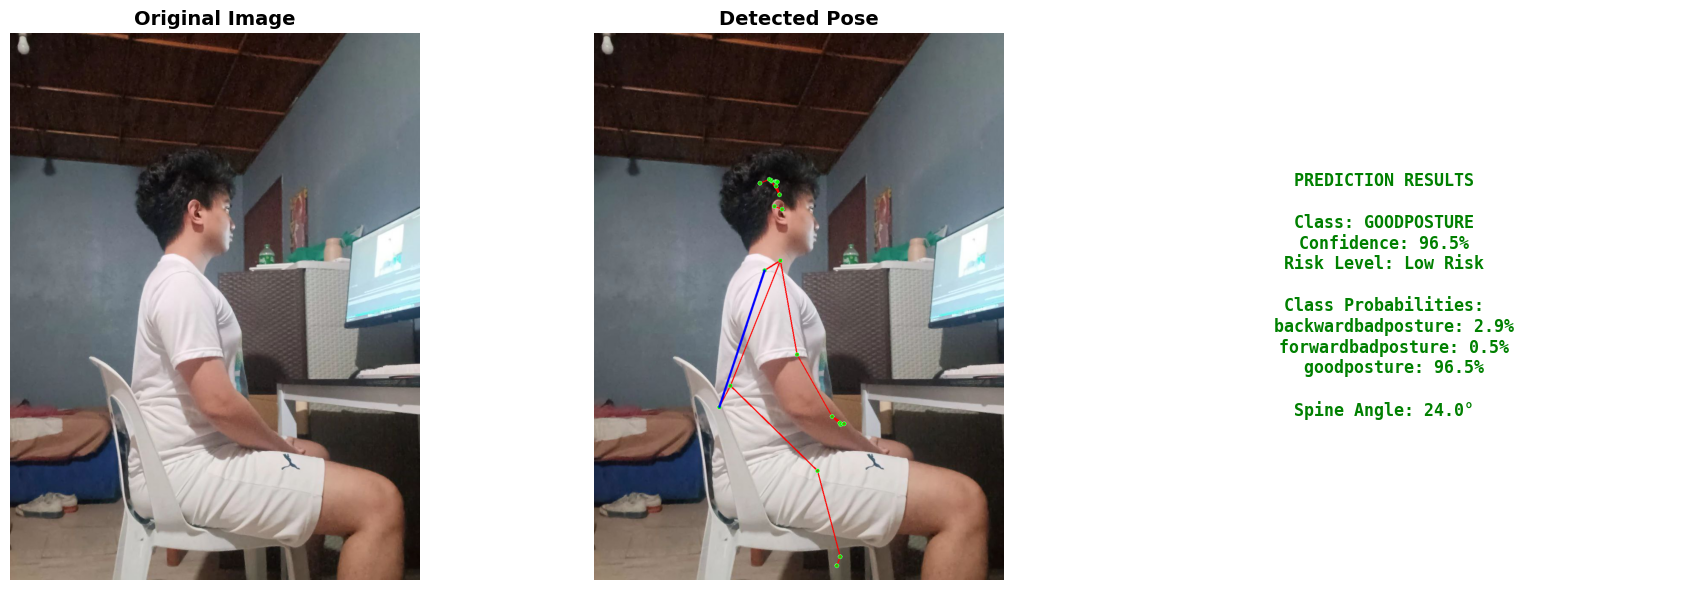


PREDICTION SUMMARY
Predicted Class: goodposture
Confidence: 96.5%
Risk Level: Low Risk
Spine Angle: 24.0°


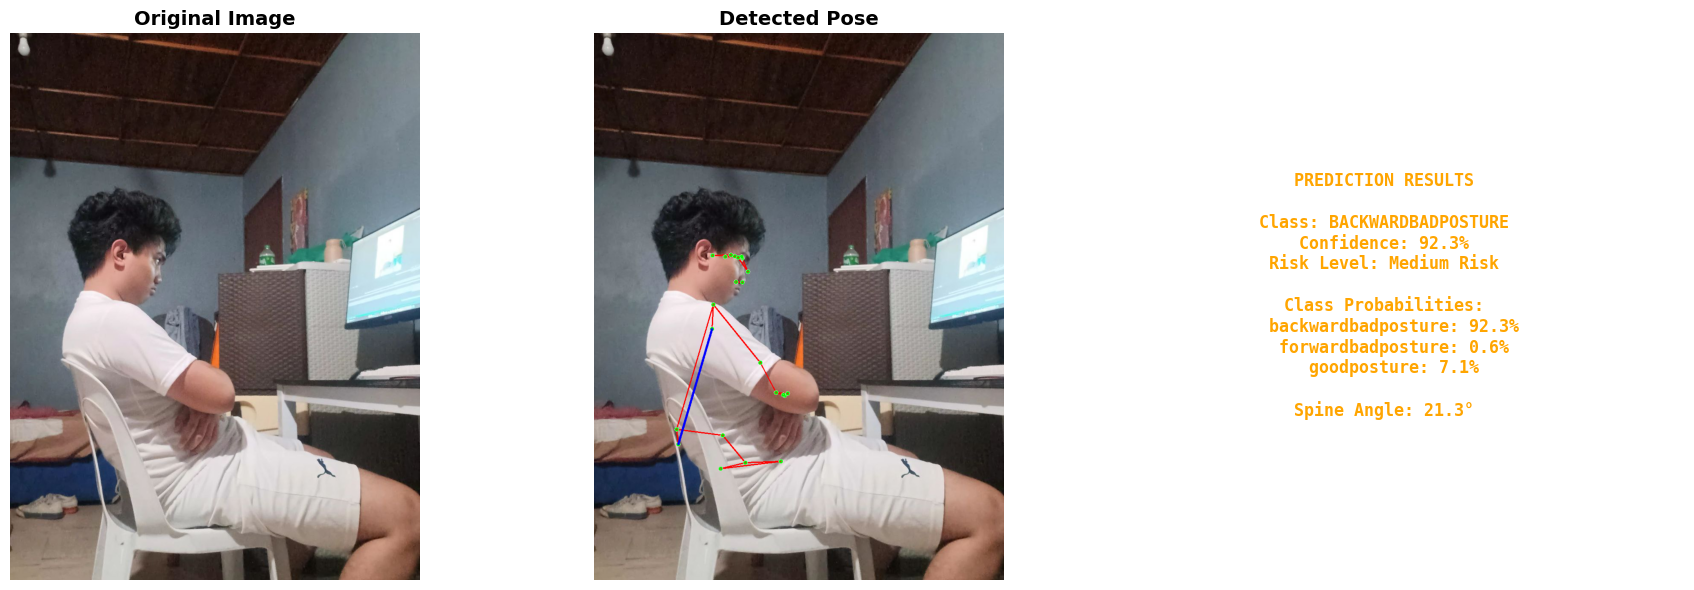


PREDICTION SUMMARY
Predicted Class: backwardbadposture
Confidence: 92.3%
Risk Level: Medium Risk
Spine Angle: 21.3°


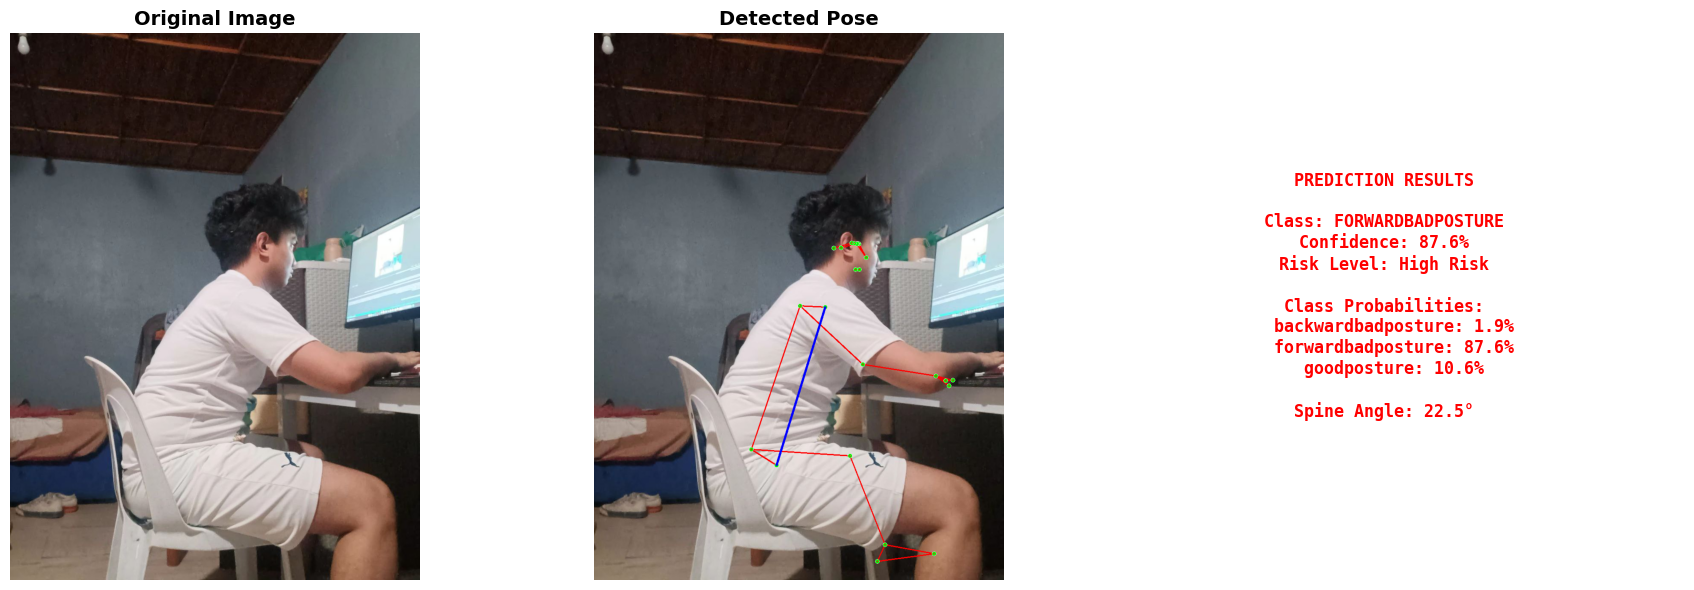


PREDICTION SUMMARY
Predicted Class: forwardbadposture
Confidence: 87.6%
Risk Level: High Risk
Spine Angle: 22.5°


In [ ]:
# TEST: Make a prediction
image1 = r"C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\v1\results\own_tests\test2\good.jpg"
image2 = r"C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\v1\results\own_tests\test2\backward.jpg"
image3 = r"C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\v1\results\own_tests\test2\forward.jpg"
# Uncomment to test:
result1 = predict_posture(image1, model, device)
result2 = predict_posture(image2, model, device)
result3 = predict_posture(image3, model, device)

# Replace 'test_image_path' with your actual image and uncomment the line above"

---
## 📈 Section 6: Model Evaluation

Evaluate the model on the test set and generate performance metrics.

Evaluating model on test set...

EVALUATION RESULTS

Test Accuracy: 95.60%

Classification Report:
                    precision    recall  f1-score   support

backwardbadposture       0.96      0.96      0.96        26
 forwardbadposture       0.95      0.95      0.95        22
       goodposture       0.95      0.95      0.95        43

          accuracy                           0.96        91
         macro avg       0.96      0.96      0.96        91
      weighted avg       0.96      0.96      0.96        91



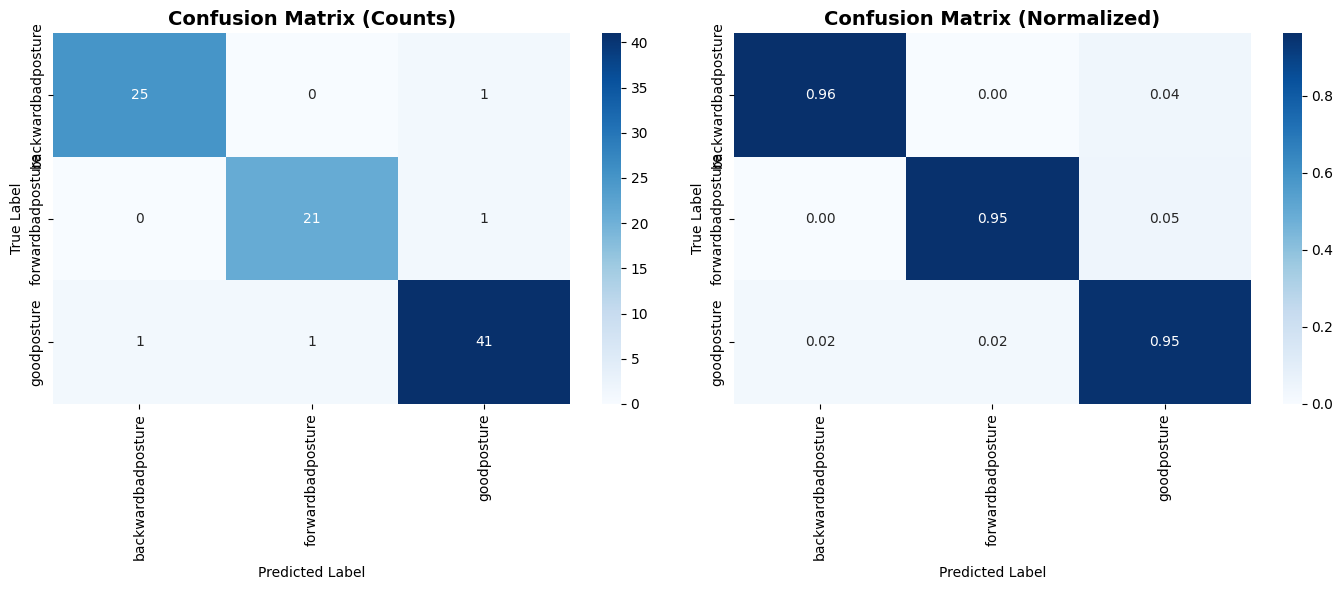

In [ ]:
# Evaluate on test set (if available)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

EVALUATE_MODEL = True  # Set to True when you have test data

if EVALUATE_MODEL and LOAD_DATASET and test_loader is not None:
    print("Evaluating model on test set...\n")
    
    model.eval()
    all_labels = []
    all_predictions = []
    all_probabilities = []
    
    with torch.no_grad():
        for images, pose_features, labels in test_loader:
            images = images.to(device)
            pose_features = pose_features.to(device)
            
            logits = model(images, pose_features)
            probabilities = torch.softmax(logits, dim=1)
            _, predictions = torch.max(logits, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probabilities = np.array(all_probabilities)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    
    print("="*60)
    print("EVALUATION RESULTS")
    print("="*60)
    print(f"\nTest Accuracy: {accuracy*100:.2f}%\n")
    print("Classification Report:")
    print(classification_report(all_labels, all_predictions, target_names=POSTURE_CLASSES))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Absolute counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=POSTURE_CLASSES, yticklabels=POSTURE_CLASSES, ax=axes[0])
    axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')
    
    # Normalized
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=POSTURE_CLASSES, yticklabels=POSTURE_CLASSES, ax=axes[1])
    axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('True Label')
    axes[1].set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("⏭️ Skipping evaluation.")
    print("   Set EVALUATE_MODEL=True and ensure test_loader is available.")

---
## 🎨 Section 7: Batch Prediction

Process multiple images and generate statistics.

In [ ]:
# Batch prediction function
def predict_batch(image_directory, model, device, max_images=10):
    """
    Predict posture for all images in a directory.
    """
    from pathlib import Path
    from tqdm.notebook import tqdm
    import pandas as pd
    
    image_dir = Path(image_directory)
    
    # Get all images
    image_files = list(image_dir.glob('*.jpg')) + \
                  list(image_dir.glob('*.jpeg')) + \
                  list(image_dir.glob('*.png'))
    
    image_files = image_files[:max_images]  # Limit for demo
    
    print(f"Found {len(image_files)} images to process...\n")
    
    results = []
    
    for image_path in tqdm(image_files, desc="Processing images"):
        try:
            # Load and predict
            image = cv2.imread(str(image_path))
            result = pose_extractor.extract_features(image)
            
            if result is None:
                continue
            
            features, debug_info = result
            
            # Prepare tensors
            from PIL import Image
            transform = get_posture_transforms('test')
            pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            image_tensor = transform(pil_image).unsqueeze(0).to(device)
            pose_tensor = torch.from_numpy(features).unsqueeze(0).to(device)
            
            # Predict
            with torch.no_grad():
                logits = model(image_tensor, pose_tensor)
                probabilities = torch.softmax(logits, dim=1)
                confidence, predicted = torch.max(probabilities, 1)
            
            # Store results
            results.append({
                'filename': image_path.name,
                'class': POSTURE_CLASSES[predicted.item()],
                'confidence': confidence.item(),
                'risk_level': POSTURE_RISK_MAPPING[POSTURE_CLASSES[predicted.item()]],
                'spine_angle': debug_info['spine_angle']
            })
            
        except Exception as e:
            print(f"Error processing {image_path.name}: {e}")
    
    # Create DataFrame
    df = pd.DataFrame(results)
    
    # Display summary
    print("\n" + "="*60)
    print("BATCH PREDICTION SUMMARY")
    print("="*60)
    print(f"\nSuccessfully processed: {len(results)} images\n")
    print("Class Distribution:")
    print(df['class'].value_counts())
    print("\nRisk Level Distribution:")
    print(df['risk_level'].value_counts())
    print("\nAverage Confidence by Class:")
    print(df.groupby('class')['confidence'].mean())
    print("="*60)
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Class distribution
    df['class'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'orange', 'red'])
    axes[0].set_title('Predicted Class Distribution', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Count')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Confidence distribution
    df.boxplot(column='confidence', by='class', ax=axes[1])
    axes[1].set_title('Confidence by Class', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Confidence')
    plt.suptitle('')  # Remove default title
    
    plt.tight_layout()
    plt.show()
    
    return df

print("✅ Batch prediction function ready!")
print("\n📝 Usage: df = predict_batch('path/to/image/folder', model, device)")

✅ Batch prediction function ready!

📝 Usage: df = predict_batch('path/to/image/folder', model, device)


Found 41 images to process...



Processing images:   0%|          | 0/41 [00:00<?, ?it/s]


BATCH PREDICTION SUMMARY

Successfully processed: 41 images

Class Distribution:
class
goodposture    41
Name: count, dtype: int64

Risk Level Distribution:
risk_level
Low Risk    41
Name: count, dtype: int64

Average Confidence by Class:
class
goodposture    0.998315
Name: confidence, dtype: float64


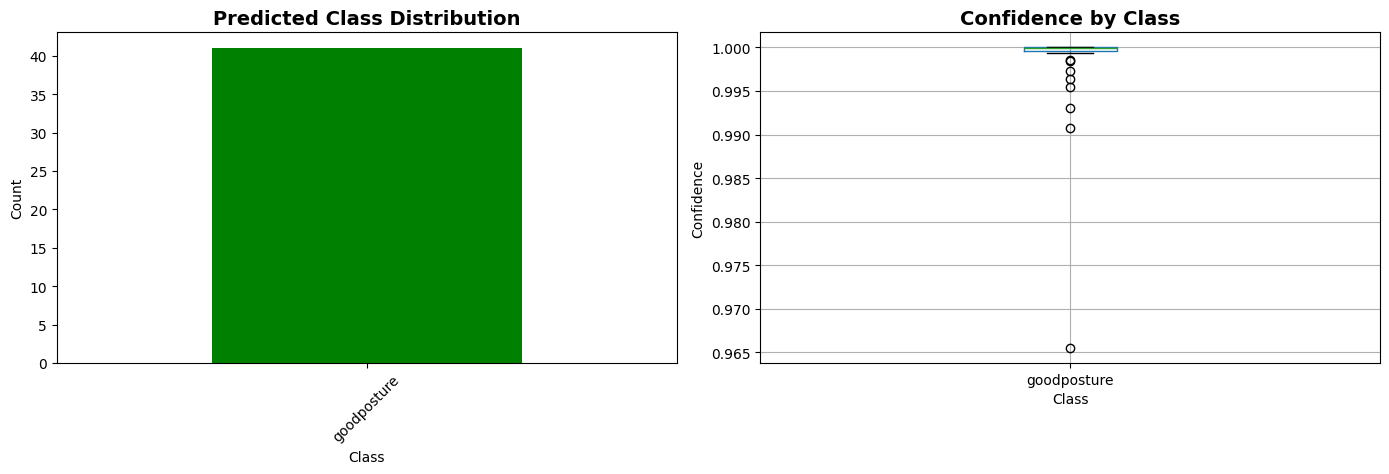


Detailed Results:
                                             filename        class  \
0   good_posture-310-_jpg.rf.5019130b8a4702b238105...  goodposture   
1   good_posture-317-_jpg.rf.b79ba01adbf8c690ee9c3...  goodposture   
2   good_posture-339-_jpg.rf.3d55bcfffa17031385530...  goodposture   
3   good_posture-341-_jpg.rf.2bd8256929c5e903d51a5...  goodposture   
4   good_posture-351-_jpg.rf.cb2cb3b6f8c115b644c16...  goodposture   
5   good_posture-353-_jpg.rf.17f0f5ca50281fd7ee39b...  goodposture   
6   good_posture-355-_jpg.rf.c93ca22c347a0cde377c9...  goodposture   
7   good_posture-357-_jpg.rf.8cca70c1d535a2df83045...  goodposture   
8   good_posture-379-_jpg.rf.025afa367b380aa16503f...  goodposture   
9   good_posture-384-_jpg.rf.6001c3284991441f44777...  goodposture   
10  good_posture-387-_jpg.rf.97e1b5c44d4ac4227e458...  goodposture   
11  good_posture-425-_jpg.rf.3554f4a88280792d89a23...  goodposture   
12  good_posture-431-_jpg.rf.89d24bd99bea6f0771c81...  goodposture   
1

In [ ]:
# TEST: Batch prediction
batch_image_dir = r"C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\v2\data\raw\test\goodposture"

# Uncomment to test:
results_df = predict_batch(batch_image_dir, model, device, max_images=100)
print("\nDetailed Results:")
print(results_df)

# Replace 'batch_image_dir' and uncomment to process multiple images"

In [ ]:
from pathlib import Path

from v2.scripts.live_demo import RealtimePostureClassifier

classifier = RealtimePostureClassifier(
        checkpoint_path=Path(r"C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\v2\checkpoints\best_model.pth"),
        camera_id=1,
        show_fps=True
    )

classifier.run()

Using device: cuda
Loading model...
MODEL ARCHITECTURE
Fusion Type: concatenation
Total Parameters: 11,543,236
Trainable Parameters: 11,543,236
Model Size: 44.03 MB (float32)


c:\Users\Admin\anaconda3\envs\ergovision\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\ergovision\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\v2\scripts\live_demo.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unp

✅ Loaded model from C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\v2\checkpoints\best_model.pth
   Model accuracy: 98.36%
Initializing pose detector...
Opening camera 1...


RuntimeError: Failed to open camera 1

In [ ]:
from v2.scripts.evaluate_model import evaluate_model
from pathlib import Path

checkpoint_str = r"C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\v2\checkpoints\best_model.pth"
checkpoint_path = Path(checkpoint_str)
test_str = r"C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\yolo_dataset\test"
test_dir = Path(test_str)
evaluate_model(test_dir, checkpoint_path)

Loading model...


c:\Users\Admin\anaconda3\envs\ergovision\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\ergovision\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\v2\scripts\evaluate_model.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code durin

MODEL ARCHITECTURE
Fusion Type: concatenation
Total Parameters: 11,543,236
Trainable Parameters: 11,543,236
Model Size: 44.03 MB (float32)
✅ Loaded checkpoint from C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\v2\checkpoints\best_model.pth
   Validation accuracy: 98.36%

Loading test dataset...
Loading test dataset from C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\yolo_dataset\test...
Found 94 images in 3 classes
Extracting pose features for test split...


Extracting poses: 100%|██████████| 94/94 [00:02<00:00, 34.20it/s]


Successfully extracted 91 pose features
Failed to detect pose in 3 images
Test set loaded: 91 samples

Evaluating on test set...



Testing: 100%|██████████| 1/1 [00:14<00:00, 14.89s/it]



GAMER ERGOVISION - TEST SET CLASSIFICATION REPORT

Test Accuracy: 96.70%
Total Test Samples: 91

Classification Report:
                   precision    recall  f1-score   support

Reclined/Backward       0.96      0.96      0.96        26
     Forward Lean       1.00      0.92      0.96        24
     Neutral/Good       0.95      1.00      0.98        41

         accuracy                           0.97        91
        macro avg       0.97      0.96      0.96        91
     weighted avg       0.97      0.97      0.97        91

Per-Class Sample Counts:
  Reclined/Backward: 26
  Forward Lean: 24
  Neutral/Good: 41

Confusion Matrix:

                  Reclined/Backward      Forward Lean      Neutral/Good 
----------------------------------------------------------------------
Reclined/Backward                25                 0                 1 
     Forward Lean                 1                22                 1 
     Neutral/Good                 0                 0            

(0.967032967032967,
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 2, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2]),
 array([[9.99984384e-01, 5.73463603e-06, 9.94540824e-06],
        [9.99750316e-01, 5.09957172e-05, 1.98679438e-04],
        [9.99667645e-01, 1.45624945e-04, 1.86740217e-04],
        [9.99686003e-01, 7.39320021e-05, 2.40092253e-04],
        [9.98166263e-01, 4.83775861e-04, 1.34995603e-03],
        [9.99830961e-01, 1.07067717e-04, 6.20316714e-05],
  

In [ ]:
from v2.scripts.generate_confusion_matrix import generate_confusion_matrix
from pathlib import Path

checkpoint_str = r"C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\v1\models\posture_classifier.pth"
checkpoint_path = Path(checkpoint_str)
test_str = r"C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\yolo_dataset\test"
test_dir = Path(test_str)
output_str = r"C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\v1\results\confusion_matrix.png"
output_path = Path(output_str)

generate_confusion_matrix(
        test_dir=test_dir,
        checkpoint_path=checkpoint_path,
        output_path=output_path,
        normalize=True,
        cmap='Blues'
    )

CONFUSION MATRIX GENERATOR

Using device: cuda
Loading model...


c:\Users\Admin\anaconda3\envs\ergovision\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\ergovision\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


CONFUSION MATRIX GENERATOR

Using device: cuda
Loading model...


c:\Users\Admin\anaconda3\envs\ergovision\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\ergovision\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\v2\scripts\generate_confusion_matrix.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary

MODEL ARCHITECTURE
Fusion Type: concatenation
Total Parameters: 11,543,236
Trainable Parameters: 11,543,236
Model Size: 44.03 MB (float32)
✅ Loaded checkpoint: C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\v2\checkpoints\best_model.pth

Loading test data from: C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\yolo_dataset\test
Loading test dataset from C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\yolo_dataset\test...
Found 94 images in 3 classes
Extracting pose features for test split...


Extracting poses: 100%|██████████| 94/94 [00:02<00:00, 33.08it/s]


Successfully extracted 91 pose features
Failed to detect pose in 3 images
Test set size: 91 samples

Running inference...


Testing: 100%|██████████| 1/1 [00:10<00:00, 10.90s/it]



Generating confusion matrix...

✅ Confusion matrix saved to: C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\v2\results\confusion_matrix.png

Overall Accuracy: 96.70%

Per-Class Metrics:

Backward Bad:
  Precision: 96.15%
  Recall: 96.15%
  F1-Score: 96.15%
  Support: 26

Forward Bad:
  Precision: 100.00%
  Recall: 91.67%
  F1-Score: 95.65%
  Support: 24

Good Posture:
  Precision: 95.35%
  Recall: 100.00%
  F1-Score: 97.62%
  Support: 41




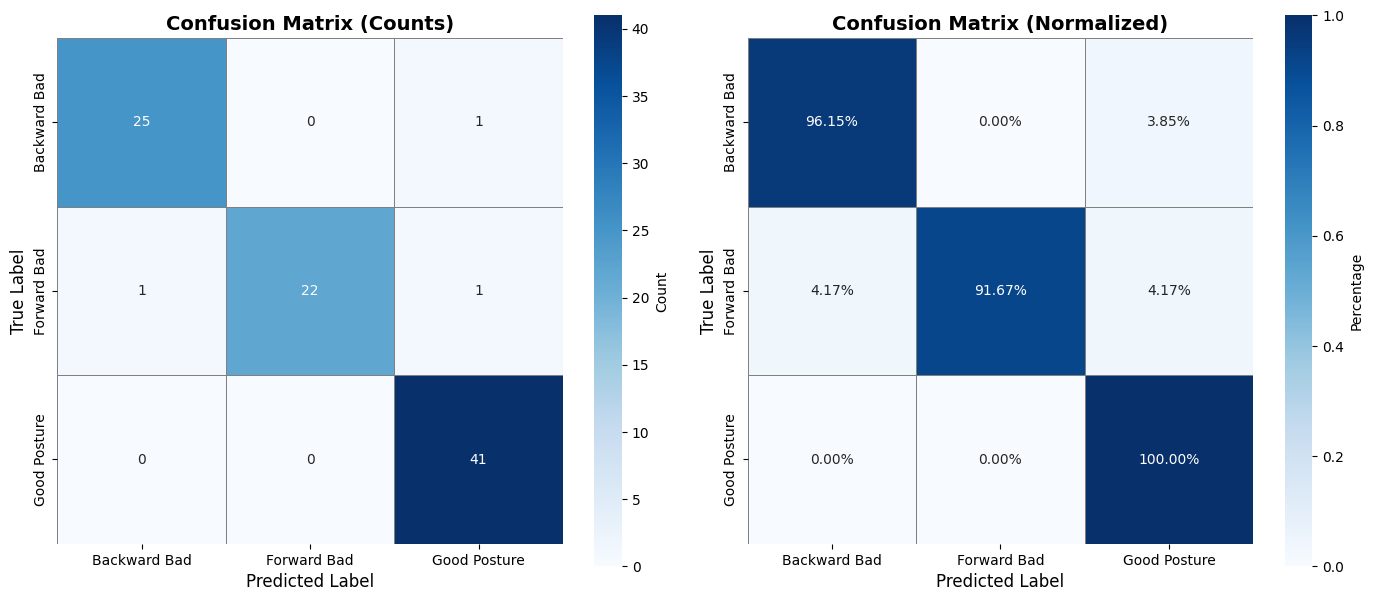

(array([[25,  0,  1],
        [ 1, 22,  1],
        [ 0,  0, 41]]),
 array([[0.96153846, 0.        , 0.03846154],
        [0.04166667, 0.91666667, 0.04166667],
        [0.        , 0.        , 1.        ]]))

In [ ]:
from v2.scripts.generate_confusion_matrix import generate_confusion_matrix
from pathlib import Path

checkpoint_str = r"C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\v2\checkpoints\best_model.pth"
checkpoint_path = Path(checkpoint_str)
test_str = r"C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\yolo_dataset\test"
test_dir = Path(test_str)
output_str = r"C:\Users\Admin\Desktop\School\CSC173\final project\CSC173-DeepCV-Lluch\v2\results\confusion_matrix.png"
output_path = Path(output_str)

generate_confusion_matrix(
        test_dir=test_dir,
        checkpoint_path=checkpoint_path,
        output_path=output_path,
        normalize=True,
        cmap='Blues'
    )

---
## 🎉 Summary & Next Steps

Congratulations! You've completed the Gamer ErgoVision pipeline.

### What You Learned:
✅ Pose feature extraction with MediaPipe  
✅ Hybrid model architecture  
✅ Dataset preparation and loading  
✅ Model training with consistency loss  
✅ Single and batch inference  
✅ Model evaluation and visualization  

### Next Steps:
1. **Collect your own dataset** of sitting posture images
2. **Train the model** on your data
3. **Experiment with hyperparameters** in `config.py`
4. **Try different fusion strategies** (weighted_addition, cross_attention)
5. **Deploy in real-time** using webcam (see `demo_side_view.py`)
6. **Extend the model** for multi-view or temporal analysis

### Resources:
- 📖 Full Documentation: `README.md`
- 🔧 Setup Guide: `SETUP.md`
- ⚡ Quick Start: `QUICKSTART.md`
- 📊 Project Summary: `PROJECT_SUMMARY.md`

### Get Help:
- Review code comments in Python files
- Check troubleshooting section in `SETUP.md`
- Open an issue on GitHub

---

**Happy posture monitoring! 🎮💺**